In [ ]:
!pip install numpy==1.23 #Needed for compatibility of packages in Kaggle
!pip install Pillow

from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape, BatchNormalization, LeakyReLU, Dropout
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2

np.random.seed(2809)

# Helper functions

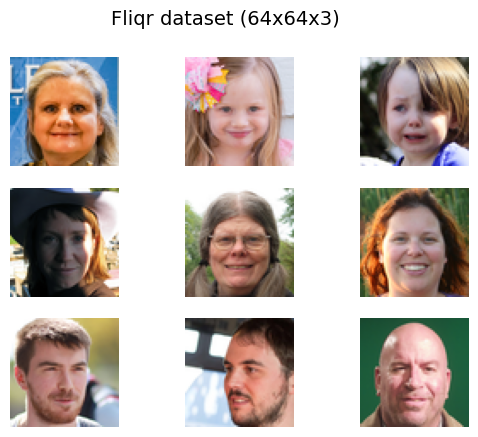

In [2]:
def load_real_samples(scale=False):
    # We load 20,000 samples only to avoid memory issues, you can  change this value
    X = np.load('/kaggle/input/faces64x64/face_dataset_64x64.npy',  fix_imports=True,encoding='latin1')[:20000, :, :, :]
    # Scale samples in range [-127, 127]
    if scale:
        X = (X - 127.5) * 2
    return X / 255.

# We will use this function to display the output of our models throughout this notebook
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()


dataset = load_real_samples()
grid_plot(dataset[np.random.randint(0, 1000, 9)], name='Fliqr dataset (64x64x3)', n=3)

# Preprocessing new image data

In [3]:
# This directory contains 13594 different images of butterflies
image_directory = '/kaggle/input/butterflies2/butterflies2/'
images = []

# Read and process all image files 
for filename in os.listdir(image_directory):
    if filename.endswith('.jpg'):
        # Open and convert image to numpy array
        image_path = os.path.join(image_directory, filename)
        img = Image.open(image_path)
        img_array = np.asarray(img)
        
        # Resize image to 64x64 using cubic interpolation
        img_array = cv2.resize(img_array, dsize=(64,64), interpolation=cv2.INTER_CUBIC)

        # Append the image array to the list
        images.append(img_array)

# Combine all image arrays into a single numpy array
# Divide by 255.0 to scale values to 0-1
butterflies = np.stack(images)/255.0

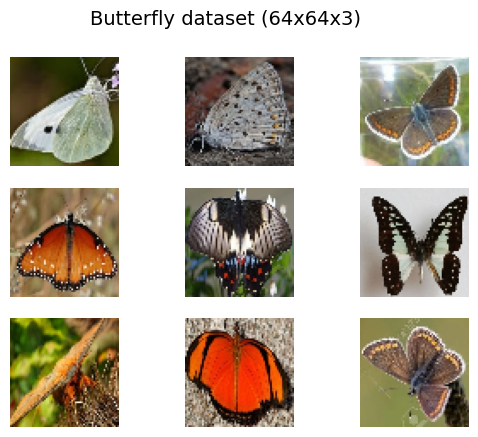

In [4]:
grid_plot(butterflies[np.random.randint(0, 1000, 9)], name='Butterfly dataset (64x64x3)', n=3)

In [11]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.8, 1.2))

additional_data = data_augmentation.flow_from_directory(
    '/kaggle/input/butterflies2/',
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=64,
    shuffle=True,
    class_mode=None,
    seed=2809)


Found 13594 images belonging to 1 classes.


In [12]:
new_butterflies = None

for i in range(45):
    new_batch = additional_data.next()
    new_batch /= 255.0
    
    if i == 0:
        new_butterflies = new_batch
    else:
        new_butterflies = np.vstack((new_batch, new_butterflies))

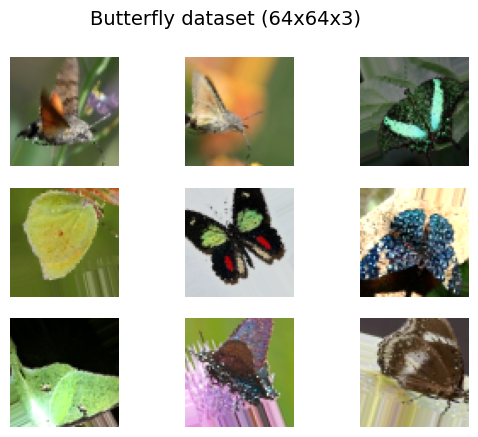

In [13]:
grid_plot(new_butterflies[np.random.randint(0, 1000, 9)], name='Butterfly dataset (64x64x3)', n=3)

In [14]:
butterfly_data = np.vstack((butterflies, new_butterflies))
np.random.shuffle(butterfly_data)
butterfly_data.shape

(16474, 64, 64, 3)

# Convolutional upsampling & downsampling architecture

In [15]:
def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim))
    model.add(Reshape((4, 4, 64))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

## Adjusted code

In [38]:
def custom_disc(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
  
    model = tf.keras.Sequential()
    model.add(Conv2D(filters=3, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=LeakyReLU(0.2)))
    model.add(Conv2D(filters=100, kernel_size=(5, 5), strides=(2, 2), padding='same', activation=LeakyReLU(0.2)))
    model.add(Conv2D(filters=500, kernel_size=(4, 4), strides=(2, 2), padding='same', activation=LeakyReLU(0.2)))
    model.add(Conv2D(filters=1000, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=LeakyReLU(0.2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


def custom_gen(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim))
    model.add(Reshape((4, 4, 64))) # This matches the output size of the downsampling architecture

    model.add(Conv2DTranspose(filters=1000, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(filters=500, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(filters=100, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh'))

    # This last convolutional layer converts back to 3 channel RGB image
    model.summary()
    return model

# Variational autoencoder

In [48]:
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae


## Train on face data

In [ ]:
# Training the VAE model
latent_dim = 32
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(20):
    latent_vectors = np.random.randn(9, latent_dim)
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8)

    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

## Train on butterfly data

In [ ]:
# Training the VAE model
latent_dim = 32
encoder, decoder, vae = build_vae(butterfly_data.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(20):
    latent_vectors = np.random.randn(9, latent_dim)
    vae.fit(x=butterfly_data, y=butterfly_data, epochs=1, batch_size=8)

    images = decoder(latent_vectors)
    grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

## Interpoloting visualizations

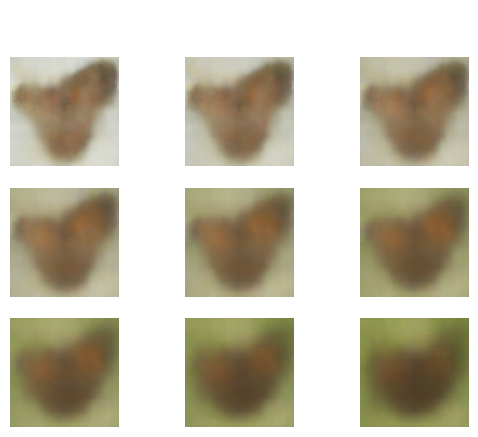

In [51]:
np.random.seed(12)
start_point = np.random.normal(0,1,latent_dim)
end_point = np.random.normal(0,1,latent_dim)
interpol_points = []
npoints = 1000

for i in np.linspace(0,1,npoints):
    inter_point = (1-i)*start_point+i*end_point
    interpol_points.append(inter_point)

interpol_points = np.stack(interpol_points)
interp_images = decoder(interpol_points).numpy()
grid_plot(interp_images[np.arange(0,1000,100)])

In [52]:
frame_images = []
for i, point in enumerate(interp_images):
    image = (point*255).astype(np.uint8)
    frame_images.append(image)
    
vidcodec = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("interpolation_animation.mp4", vidcodec, npoints // (100/1000), (64, 64), isColor=True)

for frame in frame_images:
    out.write(frame)
out.release()

# Generative Adversarial Network

In [18]:
def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)

    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator, generator, GAN


## Adjusted code

In [20]:
def custom_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = custom_gen(latent_dim, activation_out='tanh', filters=filters)

    # Build and compile the discriminator
    discriminator = custom_disc(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator, generator, GAN


In [21]:
def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)


def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in tqdm(range(batches_per_epoch)):

            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)


## Applying to face data

In [ ]:
## Build and train the model (need around 10 epochs to start seeing some results)

latent_dim = 256
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True)

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=20)

## Applying to butterfly data & interpolation of visualizations

### Original code

In [ ]:
latent_dim = 256
discriminator, generator, gan = build_gan(butterfly_data.shape[1:], latent_dim, filters=128)
butterflies_scaled = (butterfly_data-0.5)*2

train_gan(generator, discriminator, gan, butterflies_scaled, latent_dim, n_epochs=20)

32/32 [==============================] - 0s 13ms/step


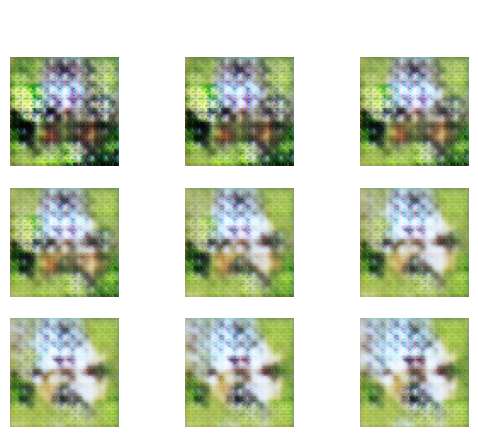

In [43]:
np.random.seed(2809)
start_point_gan = np.random.normal(0,1,latent_dim)
end_point_gan = np.random.normal(0,1,latent_dim)
interpol_points_gan = []
npoints = 1000

for i in np.linspace(0,1,npoints):
    inter_point = (1-i)*start_point_gan+i*end_point_gan
    interpol_points_gan.append(inter_point)

interpol_points_gan = np.stack(interpol_points_gan)
interp_images_gan = generator.predict([interpol_points_gan])
grid_plot(interp_images_gan[np.arange(0,1000,100)], scale=True)

In [60]:
frame_images = []
for i, point in enumerate(interp_images_gan):
    image = ((point+1)/2*255).astype(np.uint8)
    frame_images.append(image)
    
vidcodec = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("interpolation_animation_gan1.mp4", vidcodec, npoints // (100/1000), (64, 64), isColor=True)

for frame in frame_images:
    out.write(frame)
out.release()

### Adjusted code

In [ ]:
latent_dim = 256
discriminator2, generator2, gan2 = custom_gan(butterfly_data.shape[1:], latent_dim, filters=128)
butterflies_scaled = (butterfly_data-0.5)*2

train_gan(generator2, discriminator2, gan2, butterflies_scaled, latent_dim, n_epochs=20)

32/32 [==============================] - 1s 27ms/step


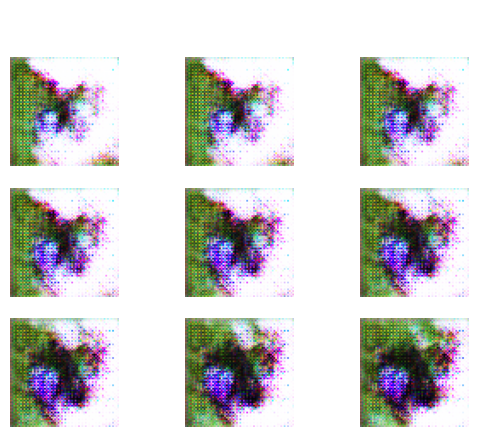

In [46]:
np.random.seed(2809)
start_point_gan2 = np.random.normal(0,1,latent_dim)
end_point_gan2 = np.random.normal(0,1,latent_dim)
interpol_points_gan2 = []
npoints = 1000

for i in np.linspace(0,1,npoints):
    inter_point = (1-i)*start_point_gan2+i*end_point_gan2
    interpol_points_gan2.append(inter_point)

interpol_points_gan2 = np.stack(interpol_points_gan2)
interp_images_gan2 = generator2.predict([interpol_points_gan2])
grid_plot(interp_images_gan2[np.arange(0,1000,100)], scale=True)

In [57]:
frame_images = []
for i, point in enumerate(interp_images_gan2):
    image = ((point+1)/2*255).astype(np.uint8)
    frame_images.append(image)
    
vidcodec = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("interpolation_animation_gan2.mp4", vidcodec, npoints // (100/1000), (64, 64), isColor=True)

for frame in frame_images:
    out.write(frame)
out.release()